In [1]:
from geoband.API import *
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import geopandas as gpd
import pandas as pd
import json
from pandas import json_normalize
import pandas as pd
import folium
from folium.plugins import MarkerCluster
from geoband.API import *
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore")
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
from geopandas import GeoDataFrame
from folium import Choropleth
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
from datetime import datetime 
import seaborn as sns
# GetCompasData로 주피터 노트북 경로에 파일 저장
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, LineString
from fiona.crs import from_string
from splot.esda import moran_scatterplot
from splot.esda import lisa_cluster
from splot.esda import plot_local_autocorrelation
from mgwr.utils import shift_colormap, truncate_colormap
import statsmodels.api as sm

matplotlib.rcParams['font.family']="Malgun Gothic"

In [2]:
from geoband.API import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import json
import geopandas as gpd
import os
import pydeck as pdk
import shapefile

In [3]:
#변수선택법

import time
import itertools

#회귀분석

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#공간회귀분석

import pysal
import libpysal
from esda.moran import Moran
from esda.moran import Moran_Local
from libpysal.weights import Queen, Rook, KNN, DistanceBand, Kernel
from esda.getisord import G
from esda.moran import Moran
from spreg import OLS, ML_Lag, ML_Error, GM_Lag, GM_Error, TSLS

#정규성검정

from scipy.stats import shapiro

#다중공선성 체크

from statsmodels.stats.outliers_influence import variance_inflation_factor


#지리적가중회귀분석

from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import compare_surfaces, truncate_colormap


In [4]:
def processSubset(X,y,feature_set):
    model = sm.OLS(y,X[list(feature_set)]) # Modeling
    regr = model.fit() # model fitting
    AIC = regr.aic # model's AIC
    return {"model" : regr, "AIC" : AIC}

In [5]:
#전진선택법

def forward(X,y,predictors):

    # predictor - 현재 선택되어있는 변수
    # 데이터 변수들이 미리정의된 predictors에 있는지 없는지 확인 및 분류
    
    remaining_predictors = [p for p in X.columns.difference(['const']) if p not in predictors]
    tic = time.time()
    results = []
    for p in remaining_predictors :
        results.append(processSubset(X=X,y=y,feature_set=predictors+[p]+['const']))
    
    models = pd.DataFrame(results)
    
    best_model = models.loc[models['AIC'].argmin()] #AIC가 가장 낮은 모델을 선택
    toc = time.time()
    print("Processed ",models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic))
    print("Selected predictors:",best_model["model"].model.exog_names,"AIC: ",best_model[0])
    return best_model
    
#전진선택법 모델

def forward_model(X,y):

    Fmodels = pd.DataFrame(columns=["AIC","model"])
    tic = time.time()
     
    predictors = []
    
    for i in range(1,len(X.columns.difference(['const']))+1):
        Forward_result = forward(X=X,y=y,predictors=predictors)
        if i > 1:
            if Forward_result["AIC"] > Fmodel_before:
                break
        Fmodels.loc[i] = Forward_result
        predictors = Fmodels.loc[i]["model"].model.exog_names
        Fmodel_before = Fmodels.loc[i]["AIC"]
        predictors = [k for k in predictors if k != 'const']
    toc = time.time()
    print("Total elapsed time:",(toc-tic), "seconds.")
    
    return (Fmodels['model'][len(Fmodels['model'])])

In [6]:
#후진제거법

def backward(X,y,predictors):
    tic= time.time()
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors) - 1):
        results.append(processSubset(X=X,y=y,feature_set=list(combo)+['const']))
    models = pd.DataFrame(results)
    
    best_model = models.loc[models['AIC'].argmin()]    # 가장 낮은 AIC를 가진 모델을 선택
    toc = time.time()
    
    print("Processed ",models.shape[0], "models on", len(predictors) - 1, "predictors in",(toc-tic))
    print("Selected predictors:",best_model['model'].model.exog_names,' AIC:',best_model[0])
    return best_model
    
def backward_model(X,y) :
    Bmodels = pd.DataFrame(columns=["AIC","model"], index = range(1,len(X.columns)))
    tic = time.time()
    predictors = X.columns.difference(['const'])
    Bmodel_before = processSubset(X,y,predictors)['AIC']
    while (len(predictors) > 1):
        Backward_result = backward(X=X, y= y, predictors=predictors)
        if Backward_result['AIC'] > Bmodel_before :
            break
        Bmodels.loc[len(predictors) -1] = Backward_result
        predictors = Bmodels.loc[len(predictors) - 1]['model'].model.exog_names
        Bmodel_before = Backward_result["AIC"]
        predictors = [k for k in predictors if k != 'const']

    toc = time.time()
    print("Total elapsed time:",(toc-tic),"seconds.")
    return Bmodels["model"].dropna().iloc[0]

In [7]:
#변수선택법

def Stepwise_model(X,y):
    Stepmodels = pd.DataFrame(columns = ["AIC","model"])
    tic = time.time()
    predictors = []
    Smodel_before = processSubset(X,y,predictors + ['const'])['AIC']
    
    
    for i in range(1,len(X.columns.difference(['const']))+1) :
        Forward_result = forward(X=X,y=y,predictors = predictors) # constant added
        print('forward')
        Stepmodels.loc[i] = Forward_result
        predictors = Stepmodels.loc[i]["model"].model.exog_names
        predictors = [k for k in predictors if k != 'const']
        Backward_result = backward(X=X,y=y,predictors = predictors)
        if Backward_result["AIC"] < Forward_result["AIC"]:
            Stepmodels.loc[i] = Backward_result
            predictors = Stepmodels.loc[i]["model"].model.exog_names
            Smodel_before = Stepmodels.loc[i]["AIC"]
            predictors = [k for k in predictors if k != "const"]
            print('backward')
        if Stepmodels.loc[i]["AIC"] > Smodel_before:
            break
        else :
            Smodel_before = Stepmodels.loc[i]["AIC"]
    toc = time.time()
    print("Total elapsed time:",(toc-tic),"seconds.")
    return (Stepmodels["model"][len(Stepmodels["model"])])

## 시작

In [8]:
df = gpd.read_file("교통_250격자데이터_최종데이터프레임.geojson")
df.head(2)

,gid,총인구수,고령자수,청년수,주거용건축물면적,총건축물수,단독주거건축물,공동주거건축물,지하철_격자별개수,초중고_격자별개수,...,남자유동인구수_50대_수치,남자유동인구수_60대이상_수치,여자유동인구수_10대_수치,여자유동인구수_20대_수치,여자유동인구수_30대_수치,여자유동인구수_40대_수치,여자유동인구수_50대_수치,여자유동인구수_60대이상_수치,rep_cnt,geometry
0,다사49aa19ab,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.450,0.467647,0.071176,0.070,0.119706,0.243529,0.286471,0.216765,0.0,"MULTIPOLYGON (((126.92477 37.27077, 126.92475 ..."
1,다사49aa19ba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.689,0.746000,0.026000,0.054,0.098000,0.245000,0.367000,0.285000,0.0,"MULTIPOLYGON (((126.92475 37.27302, 126.92473 ..."


In [9]:
# 수원시 250격자 데이터
df.fillna(0, inplace=True)

# 수치형 변수만 남김
X=df.drop(['geometry', 'gid',"rep_cnt"], axis=1)
X.fillna(0, inplace=True)

# 종속변수 지정
y=pd.DataFrame(df.loc[:, 'rep_cnt'])

In [10]:
## 수원시용 250격자
gdf = gpd.read_file('32.수원시_표준격자(250M_x_250M).geojson')
gdf = gpd.GeoDataFrame(gdf, geometry=gdf.geometry)

In [11]:
#전체 독립변수를 대상으로 다중공선성 확인

vif_acc_risk = pd.DataFrame()
vif_acc_risk['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_acc_risk['features'] = X.columns
vif_acc_risk

,VIF Factor,features
0,3.706823e+01,총인구수
1,1.083809e+01,고령자수
2,2.553744e+01,청년수
3,2.602160e+00,주거용건축물면적
4,6.108786e+01,총건축물수
...,...,...
68,1.598086e+06,여자유동인구수_20대_수치
69,1.976341e+06,여자유동인구수_30대_수치
70,2.400380e+06,여자유동인구수_40대_수치
71,1.722977e+06,여자유동인구수_50대_수치


In [12]:
len(vif_acc_risk[vif_acc_risk['VIF Factor']<=10])

16

In [13]:
#독립변수들의 계수의 크기를 명확히 비교하기 위해 독립변수를 대상으로 Min-Max scaling 진행

scaler = MinMaxScaler()
scaler.fit(X)
scaled_X = scaler.transform(X)

scaled_X = pd.DataFrame(scaled_X)
scaled_X.columns = list(X.columns)

scaled_X = sm.add_constant(scaled_X, has_constant='add')

scaled_X

,const,총인구수,고령자수,청년수,주거용건축물면적,총건축물수,단독주거건축물,공동주거건축물,지하철_격자별개수,초중고_격자별개수,...,남자유동인구수_30대_수치,남자유동인구수_40대_수치,남자유동인구수_50대_수치,남자유동인구수_60대이상_수치,여자유동인구수_10대_수치,여자유동인구수_20대_수치,여자유동인구수_30대_수치,여자유동인구수_40대_수치,여자유동인구수_50대_수치,여자유동인구수_60대이상_수치
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000421,0.000645,0.001440,0.001461,0.000819,0.000182,0.000476,0.000878,0.001088,0.000919
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000518,0.000830,0.002204,0.002330,0.000299,0.000141,0.000389,0.000884,0.001394,0.001208
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000036,0.000128,0.000031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000233,0.000240,0.000468,0.000413,0.000428,0.000153,0.000358,0.000392,0.000442,0.000439
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000276,0.000284,0.000585,0.000509,0.000474,0.000158,0.000462,0.000527,0.000614,0.000529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2085,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001048,0.002319,0.004066,0.001976,0.001343,0.000277,0.000778,0.001980,0.001844,0.001040
2086,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2087,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000546,0.000637,0.000998,0.000653,0.000599,0.000201,0.000670,0.000835,0.000655,0.000553
2088,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002321,0.002764,0.004122,0.003272,0.003292,0.000925,0.002788,0.003743,0.002937,0.002965


In [14]:
#전체 독립변수를 대상으로 다중공선성 재확인

vif_acc_risk_scaled = pd.DataFrame()
vif_acc_risk_scaled['VIF Factor'] = [variance_inflation_factor(scaled_X.values, i) for i in range(scaled_X.shape[1])]
vif_acc_risk_scaled['features'] = scaled_X.columns
vif_acc_risk_scaled

,VIF Factor,features
0,1.049464e+01,const
1,2.582782e+01,총인구수
2,7.752415e+00,고령자수
3,1.827186e+01,청년수
4,1.811725e+00,주거용건축물면적
...,...,...
69,1.398373e+06,여자유동인구수_20대_수치
70,1.621426e+06,여자유동인구수_30대_수치
71,1.878453e+06,여자유동인구수_40대_수치
72,1.310755e+06,여자유동인구수_50대_수치


In [15]:
# 스케일링 전 26개 -> 스케일링 후 29개를 선택
len(vif_acc_risk_scaled[vif_acc_risk_scaled['VIF Factor']<=10])

18

In [16]:
vif_acc_risk_scaled[vif_acc_risk_scaled['VIF Factor']<=10]
# 어떤 변수들이 골라졌는지 한번 체크해보기

,VIF Factor,features
2,7.752415,고령자수
4,1.811725,주거용건축물면적
7,5.507397,공동주거건축물
8,1.430945,지하철_격자별개수
9,3.069799,초중고_격자별개수
10,4.270474,상업시설_격자별개수
11,2.587796,상업지역면적
12,1.821094,공업지역면적
13,4.814058,주거지역면적
14,2.419205,녹지지역면적


StandardScaler도 해보기

In [17]:
# 열별 정규화

standard_X=X.apply(lambda x: (x-x.mean())/ x.std(), axis=0)

In [18]:
#전체 독립변수를 대상으로 다중공선성 재확인

vif_acc_risk_standard = pd.DataFrame()
vif_acc_risk_standard['VIF Factor'] = [variance_inflation_factor(standard_X.values, i) for i in range(standard_X.shape[1])]
vif_acc_risk_standard['features'] = standard_X.columns
vif_acc_risk_standard

,VIF Factor,features
0,2.582782e+01,총인구수
1,7.752415e+00,고령자수
2,1.827186e+01,청년수
3,1.811725e+00,주거용건축물면적
4,4.574645e+01,총건축물수
...,...,...
68,1.398373e+06,여자유동인구수_20대_수치
69,1.621426e+06,여자유동인구수_30대_수치
70,1.878453e+06,여자유동인구수_40대_수치
71,1.310755e+06,여자유동인구수_50대_수치


In [19]:
# 스케일링 전 26개 -> 스케일링 후 29개를 선택
len(vif_acc_risk_standard[vif_acc_risk_standard['VIF Factor']<=10])

18

In [20]:
vif_acc_risk_standard[vif_acc_risk_standard['VIF Factor']<=10]
# 어떤 변수들이 골라졌는지 한번 체크해보기

,VIF Factor,features
1,7.752415,고령자수
3,1.811725,주거용건축물면적
6,5.507397,공동주거건축물
7,1.430945,지하철_격자별개수
8,3.069799,초중고_격자별개수
9,4.270474,상업시설_격자별개수
10,2.587796,상업지역면적
11,1.821094,공업지역면적
12,4.814058,주거지역면적
13,2.419205,녹지지역면적


<AxesSubplot:xlabel='features'>

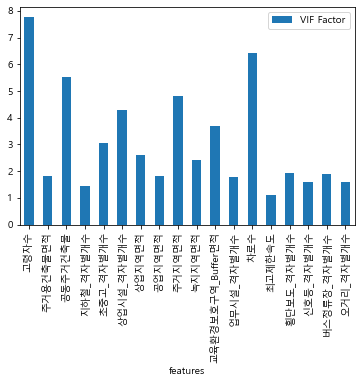

In [21]:
vif_acc_risk_standard[vif_acc_risk_standard['VIF Factor']<=10].set_index("features").plot.bar()

In [22]:
selected_X_list=list(vif_acc_risk_scaled[vif_acc_risk_scaled['VIF Factor']<=10]['features'])
selected_X_list.append('const')
scaled_X=scaled_X[selected_X_list]

In [23]:
step_best_model_ctc = Stepwise_model(scaled_X, y)

Processed  18 models on 1 predictors in 0.7006194591522217
Selected predictors: ['상업시설_격자별개수', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fd3209edb00>
forward
Processed  1 models on 0 predictors in 0.003431558609008789
Selected predictors: ['const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fd3209ede10>
Processed  17 models on 2 predictors in 0.6002719402313232
Selected predictors: ['상업시설_격자별개수', '차로수', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fd320a023c8>
forward
Processed  2 models on 1 predictors in 0.004955768585205078
Selected predictors: ['상업시설_격자별개수', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fd320a02f60>
Processed  16 models on 3 predictors in 0.6985831260681152
Selected predictors: ['상업시설_격자별개수', '차로수', '상업지역면적', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object a

In [24]:
step_best_model_ctc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                rep_cnt   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     241.9
Date:                Tue, 19 Oct 2021   Prob (F-statistic):               0.00
Time:                        18:11:57   Log-Likelihood:                -9030.8
No. Observations:                2090   AIC:                         1.809e+04
Df Residuals:                    2077   BIC:                         1.816e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
상업시설_격자별개수          127.2424      6.545     19.441      0.000     114.407     140.078
차로수                  37.6019      3.323     11.315      0.000      31.085      44.119
상업지역면적               30.3258      3.410      8.893      0.000      23.638      37.013
횡단보도_격자별개수           31.1636      5.557      5.608      0.000      20.267      42.061
주거지역면적               12.6581      2.981      4.246      0.000       6.812      18.504
신호등_격자별개수           -24.3399      4.294     -5.669      0.000     -32.760     -15.919
업무시설_격자별개수           33.2008      7.515      4.418      0.000      18.462      47.939
오거리_격자별개수            30.1685      7.014      4.301      0.000      16.413      43.924
주거용건축물면적             12.5477      3.599      3.486      0.000       5.490      19.606
교육환경보호구역_Buffer면적   -12.7164      4.346     -2.926      0.003     -21.239      -4.194
공동주거건축물               9.7337      4.806      2.025      0.043       0.308      19.159
지하철_격자별개수            10.7619      5.375      2.002      0.045       0.220      21.304
const                -1.0336      0.573     -1.803      0.072      -2.158       0.091
==============================================================================
Omnibus:                     2307.868   Durbin-Watson:                   1.540
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           438871.510
Skew:                           5.182   Prob(JB):                         0.00
Kurtosis:                      73.230   Cond. No.                         20.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
step_best_model_ctc.params

상업시설_격자별개수           127.242387
차로수                   37.601932
상업지역면적                30.325760
횡단보도_격자별개수            31.163607
주거지역면적                12.658136
신호등_격자별개수            -24.339881
업무시설_격자별개수            33.200770
오거리_격자별개수             30.168486
주거용건축물면적              12.547707
교육환경보호구역_Buffer면적    -12.716415
공동주거건축물                9.733665
지하철_격자별개수             10.761917
const                 -1.033551
dtype: float64

In [26]:
step_selected_X_list=list(step_best_model_ctc.params.index)
scaled_X=scaled_X[step_selected_X_list]

<AxesSubplot:title={'center':'Person Correlation of Features'}>

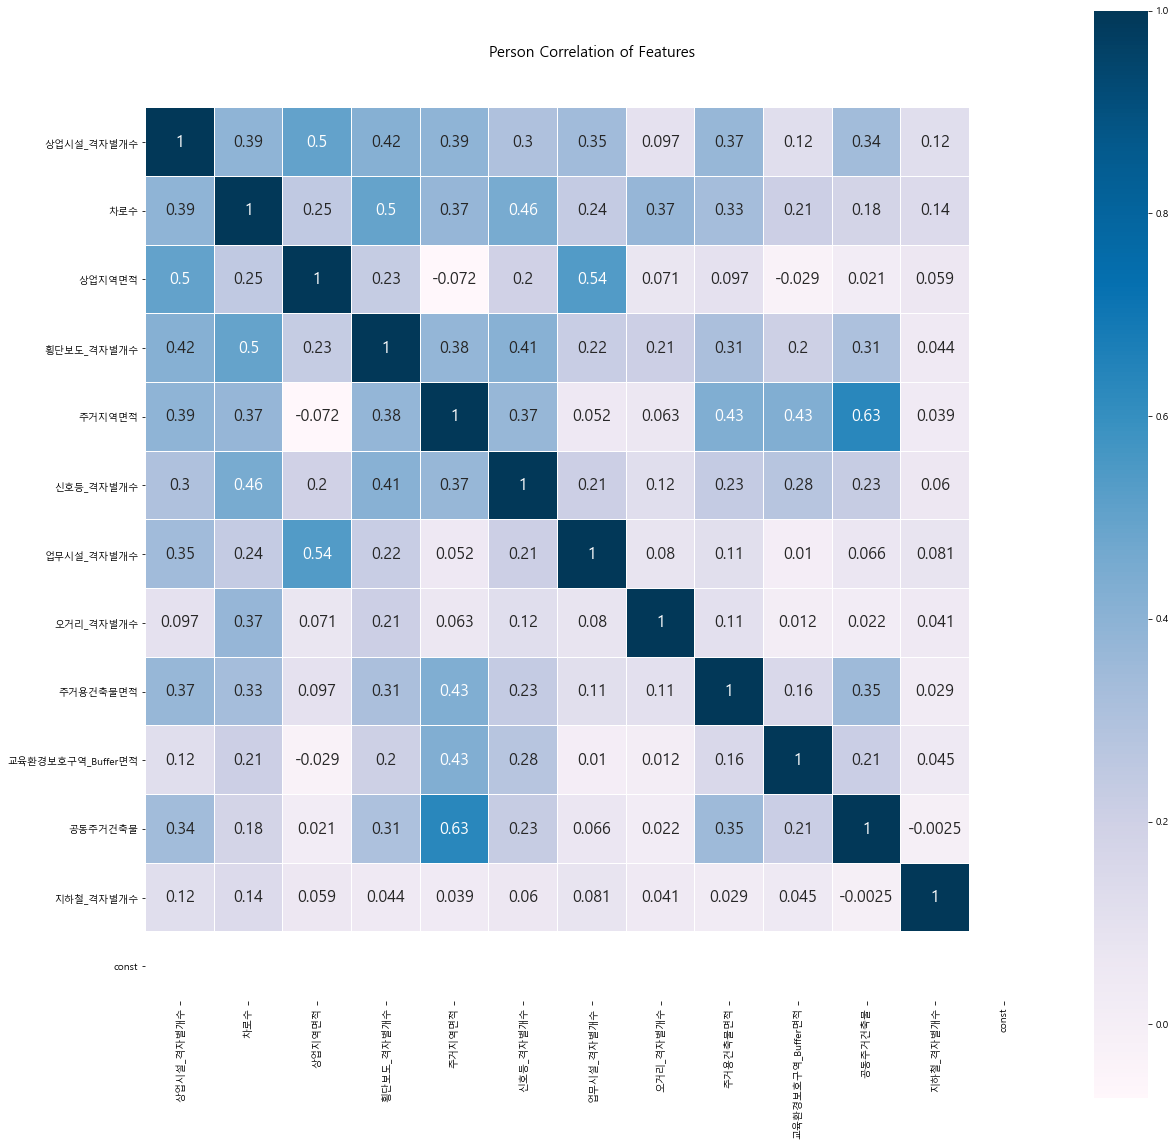

In [27]:
colormap = plt.cm.PuBu 
plt.figure(figsize=(20, 20)) 
plt.title("Person Correlation of Features", y = 1.05, size = 15) 
sns.heatmap(scaled_X.astype(float).corr(), linewidths = 0.1, vmax = 1.0, square = True, cmap = colormap, 
            linecolor = "white", annot = True, annot_kws = {"size" : 16})


### 히트맵에서 공선성 0.8 넘는거 있으면 보고 빼야함

# -------변수 선택 끝(다중공선, Stepwise)----------

In [28]:
#OLS모형을 적합하는 과정을 함수로 정의

def ols(data_x, data_y, w_matrix):
    x = np.array(data_x)
    y = np.array(data_y)
    
    name_x = list(data_x.columns)
    name_y = list(data_y.columns)
    
    ols = OLS(y = y, x = x, w = w_matrix, name_x = name_x, name_y = name_y, white_test = True, spat_diag = True, moran = True)
    
    print(ols.summary)
    
    return ols

In [29]:
#SEM_GM모형을 적합하는 과정을 함수로 정의

def gmerror(data_x, data_y, w_matrix):
    x = np.array(data_x)
    y = np.array(data_y)
    
    name_x = list(data_x.columns)
    name_y = list(data_y.columns)
    
    gmerror = GM_Error(y = y, x = x, w = w_matrix, name_x = name_x, name_y = name_y)
    
    print(gmerror.summary)
    
    return gmerror

In [30]:
#SEM_ML모형을 적합하는 과정을 함수로 정의

def mlerror(data_x, data_y, w_matrix):
    x = np.array(data_x)
    y = np.array(data_y)
    
    name_x = list(data_x.columns)
    name_y = list(data_y.columns)
    
    mlerror = ML_Error(y = y, x = x, w = w_matrix, name_x = name_x, name_y = name_y)
    stat_Q_risk, p_Q_risk = shapiro(mlerror.e_filtered)
    
    print(stat_Q_risk, p_Q_risk)
    print(mlerror.summary)
    
    return mlerror

In [31]:
#SLM_GM모형을 적합하는 과정을 함수로 정의

def gmlag(data_x, data_y, w_matrix):
    x = np.array(data_x)
    y = np.array(data_y)
    
    name_x = list(data_x.columns)
    name_y = list(data_y.columns)
    
    gmlag = GM_Lag(y = y, x = x, w = w_matrix, name_x = name_x)
    
    print(gmlag.summary)
    
    return gmlag

In [32]:
#SLM_ML모형을 적합하는 과정을 함수로 정의

def mllag(data_x, data_y, w_matrix):
    x = np.array(data_x)
    y = np.array(data_y)
    
    name_x = list(data_x.columns)
    name_y = list(data_y.columns)
    
    mllag = ML_Lag(y = y, x = x, w = w_matrix, name_x = name_x)
    
    print(mllag.summary)
    
    return mllag

In [33]:
%matplotlib inline

import matplotlib.pyplot as plt
from libpysal.weights.contiguity import Queen
from libpysal import examples
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import splot

## 회귀 모델

In [34]:
w = Queen.from_dataframe(gdf)
w.transform = 'r'

In [35]:
# 정규성 검정
shapiro(y)

ShapiroResult(statistic=0.5450221300125122, pvalue=0.0)

## 모란지수 참고
- http://pysal.org/notebooks/viz/splot/esda_morans_viz.html

In [36]:
ols_Q_ctc = ols(scaled_X, y, w)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  : ['rep_cnt']                Number of Observations:        2090
Mean dependent var  :     14.5837                Number of Variables   :          13
S.D. dependent var  :     28.2053                Degrees of Freedom    :        2077
R-squared           :      0.5830
Adjusted R-squared  :      0.5805
Sum squared residual:  693088.336                F-statistic           :    241.9350
Sigma-square        :     333.697                Prob(F-statistic)     :           0
S.E. of regression  :      18.267                Log likelihood        :   -9030.755
Sigma-square ML     :     331.621                Akaike info criterion :   18087.509
S.E of regression ML:     18.2105                Schwarz criterion     :   18160.893

-----------------------------------------------------------------------------

In [37]:
gmerror_Q_ctc = gmerror(scaled_X, y, w) #GMM 추정

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES
---------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  : ['rep_cnt']                Number of Observations:        2090
Mean dependent var  :     14.5837                Number of Variables   :          13
S.D. dependent var  :     28.2053                Degrees of Freedom    :        2077
Pseudo R-squared    :      0.5759

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      -0.4574429       0.9038627      -0.5060978       0.6127880
          상업시설_격자별개수     106.0480763       6.3467592      16.7090122       0.0000000
                 차로수      45.1363708       3.3379494      13.5221855       0.0000000
      

In [38]:
gmlag_D_cth = gmlag(scaled_X, y, w) #2SLS 추정

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:        2090
Mean dependent var  :     14.5837                Number of Variables   :          14
S.D. dependent var  :     28.2053                Degrees of Freedom    :        2076
Pseudo R-squared    :      0.6404
Spatial Pseudo R-squared:  0.5891

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      -2.0780751       0.5415903      -3.8369872       0.0001246
          상업시설_격자별개수     107.5531329       6.3868795      16.8396996       0.0000000
                 차로수      36.3533482       3.0800807      1

In [39]:
#전역적 Moran's I

mi = Moran(y, w)
mi.I, mi.p_sim

(0.4706330786949852, 0.001)

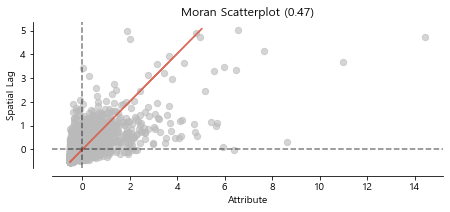

In [40]:
fig, ax = moran_scatterplot(mi, aspect_equal=True, p=0.05)
plt.show()

In [41]:
#지역적 Moran's I

mil = Moran_Local(y, w)
mil.Is.shape

(2090,)

In [42]:
mil.p_z_sim[0]

0.14714882147647168

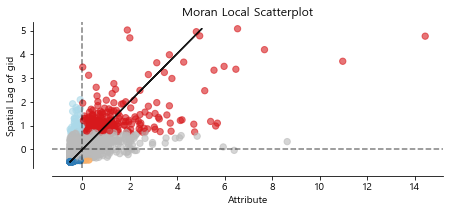

In [43]:
fig, ax = moran_scatterplot(mil, aspect_equal=True, p=0.05)
ax.set_ylabel('Spatial Lag of gid')
plt.show()

In [44]:
idx = mil.p_sim < 0.05
mil.p_sim[idx]

array([0.021, 0.021, 0.021, ..., 0.006, 0.006, 0.021])

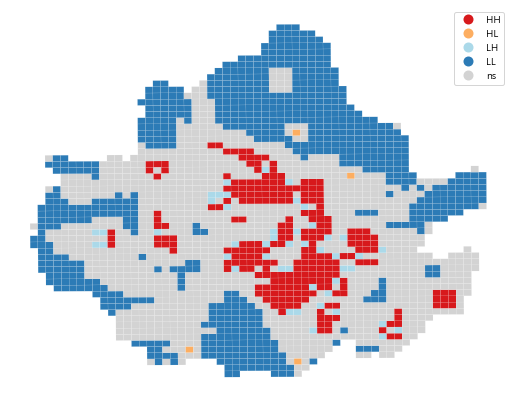

In [45]:
lisa_cluster(mil, gdf, p=0.05, figsize = (9,9))
plt.show()

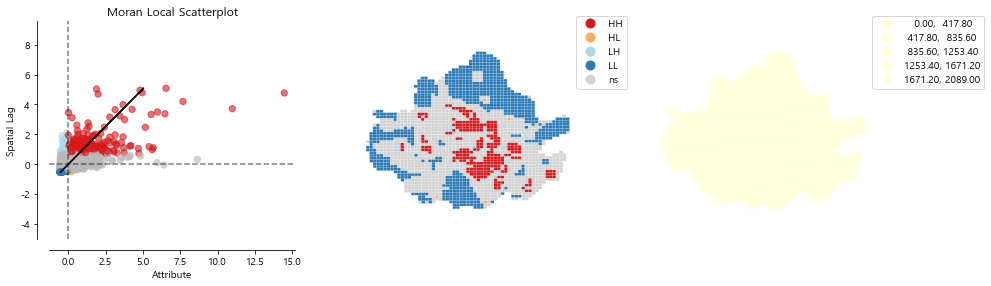

In [46]:
plot_local_autocorrelation(mil, gdf, 'gid', p=0.05)
plt.show()

In [47]:
sum(mil.q[idx] == 1), sum(mil.q[idx] == 2), sum(mil.q[idx] == 3), sum(mil.q[idx] == 4)

(252, 47, 726, 4)

In [48]:
#변수들의 데이터타입 변경

X_a = np.array(scaled_X)
y_a = np.array(y).reshape(-1,1)

In [49]:
#격자의 centroid값 저장

#gdf = gpd.GeoDataFrame(gdf, geometry=gdf.geometry)

g_coords = gdf['geometry'].centroid

x_g = g_coords.x
y_g = g_coords.y

g_coords = list(zip(x_g, y_g))

In [50]:
# GWR 분석 결과

gwr_selector_ctc = Sel_BW(g_coords, y_a, X_a, kernel='gaussian')
gwr_bw_ctc = gwr_selector_ctc.search()

In [51]:
gwr_model_ctc = GWR(g_coords, y_a, X_a, gwr_bw_ctc, fixed=False, kernel='gaussian')
gwr_result_ctc = gwr_model_ctc.fit()
gwr_result_ctc.summary()

Model type                                                         Gaussian
Number of observations:                                                2090
Number of covariates:                                                    13

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         693088.336
Log-likelihood:                                                   -9030.755
AIC:                                                              18087.509
AICc:                                                             18089.712
BIC:                                                             677209.838
R2:                                                                   0.583
Adj. R2:                                                              0.581

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### 완전 분리를 위해.. 시간 너무 오래걸림

In [52]:
localr2_df=gwr_result_ctc.localR2
np.save("gwr_localr2_교통.npy",localr2_df)

In [53]:
y_bar=gwr_result_ctc.y_bar
np.save("gwr_y_bar_교통.npy",y_bar)

In [54]:
filter_tvals=gwr_result_ctc.filter_tvals()
np.save("gwr_filter_tvals_교통.npy",filter_tvals)

In [55]:
# y fitted 값 저장
# 데이터 프레임
gwr_coef_df=pd.DataFrame(gwr_result_ctc.params, columns=scaled_X.columns)
gwr_coef_df.to_csv('gwr_coef_교통.csv', index=False)

# np.array
gwr_coef=gwr_result_ctc.params
np.save("gwr_params_교통.npy",gwr_coef)

gwr_coef_df

,상업시설_격자별개수,차로수,상업지역면적,횡단보도_격자별개수,주거지역면적,신호등_격자별개수,업무시설_격자별개수,오거리_격자별개수,주거용건축물면적,교육환경보호구역_Buffer면적,공동주거건축물,지하철_격자별개수,const
0,0.330568,90.065049,43.338938,28.991012,0.534185,2.773694,-8.143514,182.895130,70.229485,-8.666634,5.534012,18.335831,-6.393555
1,0.343127,88.775159,43.408644,30.345524,0.234270,2.385330,-7.729992,178.474073,71.451242,-8.387210,6.183346,18.266486,-6.213230
2,0.371107,86.933669,43.614742,32.985428,-0.300139,1.585922,-7.088387,166.685240,73.969378,-7.736670,7.408569,17.953687,-5.657383
3,0.269996,97.043876,43.687467,23.444737,2.104684,4.331341,-11.126748,189.695446,66.811921,-9.285503,2.726249,18.288509,-6.940278
4,0.291814,94.283904,43.565453,24.733674,1.597249,4.064543,-10.233125,192.797257,66.914816,-9.394138,3.458705,18.331147,-6.818568
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2085,-1.463703,102.769984,21.363224,7.936513,41.016921,14.568861,-8.288100,-0.323143,12.861008,12.698843,-13.370798,1.282397,26.754280
2086,-1.516059,103.845486,21.085363,9.147856,43.531196,14.524468,-10.906545,0.902956,13.694853,13.473933,-13.171114,3.790181,28.396483
2087,-1.488241,102.969863,20.500005,9.424592,45.267857,14.217991,-11.817020,0.725651,13.811107,13.695944,-12.945472,4.870218,29.104478
2088,-1.529788,104.636085,20.465594,10.721332,47.227169,14.115730,-14.105585,1.903591,14.670657,14.394609,-12.750797,7.115265,30.361350


In [56]:
scaled_X['geometry']=df['geometry']
scaled_X['gid']=df['gid']
scaled_X=gpd.GeoDataFrame(scaled_X,geometry='geometry')
scaled_X.to_file('scaled_X_교통.geojson', driver='GeoJSON')

# 시각화(완전 분리)

[Text(0, 1, 'gwr_ctc')]

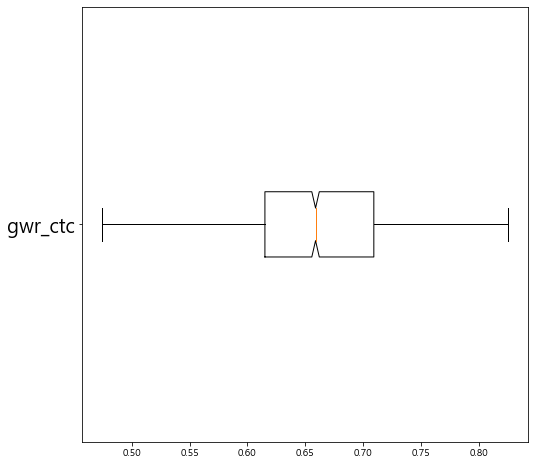

In [57]:
#모델별 R2 분포 확인
localr2=np.load("gwr_localr2_교통.npy")

plt.figure(figsize=(8, 8))
plt.boxplot([localr2.reshape(-1,)],
            vert=False, notch=True, sym="")
plt.gca().set_yticklabels(['gwr_ctc'],
                          rotation=0, fontsize=20)

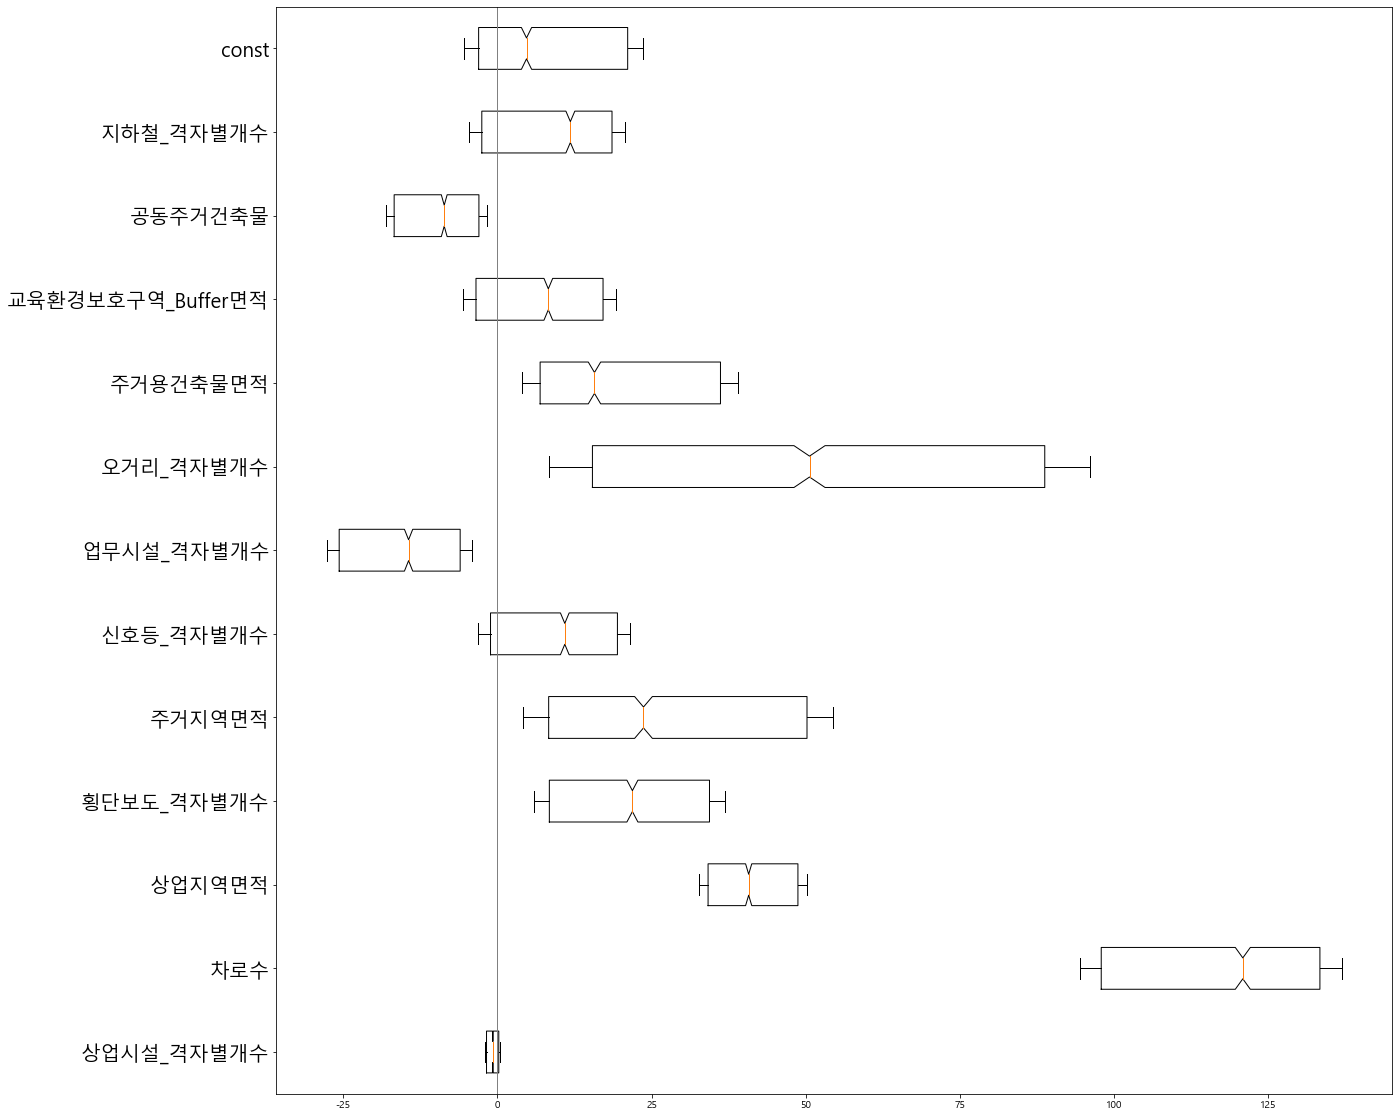

In [58]:
gwr_params=np.load("gwr_params_교통.npy")
scaled_X=gpd.read_file('scaled_X_교통.geojson', driver='GeoJSON')

plt.figure(figsize=(20, 20))

## 수동이긴 한데 변수가 16개라 하나씩 넣은거임.. 다시하면 수정 필요!
## 17은 gid, 18은 geometry
params=[]
for i in range(len(gwr_params[0])):
    params.append(gwr_params[:, i])

plt.boxplot(params, vert=False, notch=True, sym="", whis=0.1)

plt.gca().set_yticklabels(list(scaled_X.drop(['gid','geometry'], axis=1).columns),
                          rotation=0, fontsize=20)

plt.axvline(0, 0, 1, color='grey', linewidth='1')

### 챔고쓰
- https://deepnote.com/@siew-sook-yan/Python-Geographically-Weighted-Regression-GWR-vwNhTvvvTwe9W8iumNFSaw

In [59]:
# np array버전
gwr_params=np.load("gwr_params_교통.npy")
filter_tvals=np.load("gwr_filter_tvals_교통.npy")

# 분리할거면 아예 분리해야함
gwr_bw_ctc=gwr_bw_ctc

# gdf 버전(칼럼명 있음)
gwr_coef_df=pd.read_csv('gwr_coef_교통.csv')
gwr_coef_df['geometry']=scaled_X['geometry']
gwr_coef_df['gid']=scaled_X['gid']
gwr_coef_df=gpd.GeoDataFrame(gwr_coef_df,geometry='geometry')
gwr_coef_df

,상업시설_격자별개수,차로수,상업지역면적,횡단보도_격자별개수,주거지역면적,신호등_격자별개수,업무시설_격자별개수,오거리_격자별개수,주거용건축물면적,교육환경보호구역_Buffer면적,공동주거건축물,지하철_격자별개수,const,geometry,gid
0,0.330568,90.065049,43.338938,28.991012,0.534185,2.773694,-8.143514,182.895130,70.229485,-8.666634,5.534012,18.335831,-6.393555,"MULTIPOLYGON (((126.92477 37.27077, 126.92475 ...",다사49aa19ab
1,0.343127,88.775159,43.408644,30.345524,0.234270,2.385330,-7.729992,178.474073,71.451242,-8.387210,6.183346,18.266486,-6.213230,"MULTIPOLYGON (((126.92475 37.27302, 126.92473 ...",다사49aa19ba
2,0.371107,86.933669,43.614742,32.985428,-0.300139,1.585922,-7.088387,166.685240,73.969378,-7.736670,7.408569,17.953687,-5.657383,"MULTIPOLYGON (((126.92472 37.27753, 126.92470 ...",다사49aa20aa
3,0.269996,97.043876,43.687467,23.444737,2.104684,4.331341,-11.126748,189.695446,66.811921,-9.285503,2.726249,18.288509,-6.940278,"MULTIPOLYGON (((126.92766 37.26177, 126.92764 ...",다사49ab18ab
4,0.291814,94.283904,43.565453,24.733674,1.597249,4.064543,-10.233125,192.797257,66.914816,-9.394138,3.458705,18.331147,-6.818568,"MULTIPOLYGON (((126.92764 37.26402, 126.92762 ...",다사49ab18ba
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2085,-1.463703,102.769984,21.363224,7.936513,41.016921,14.568861,-8.288100,-0.323143,12.861008,12.698843,-13.370798,1.282397,26.754280,"MULTIPOLYGON (((127.08822 37.28722, 127.08821 ...",다사63ba21aa
2086,-1.516059,103.845486,21.085363,9.147856,43.531196,14.524468,-10.906545,0.902956,13.694853,13.473933,-13.171114,3.790181,28.396483,"MULTIPOLYGON (((127.08821 37.28947, 127.08820 ...",다사63ba21ab
2087,-1.488241,102.969863,20.500005,9.424592,45.267857,14.217991,-11.817020,0.725651,13.811107,13.695944,-12.945472,4.870218,29.104478,"MULTIPOLYGON (((127.08820 37.29173, 127.08819 ...",다사63ba21ba
2088,-1.529788,104.636085,20.465594,10.721332,47.227169,14.115730,-14.105585,1.903591,14.670657,14.394609,-12.750797,7.115265,30.361350,"MULTIPOLYGON (((127.08819 37.29398, 127.08818 ...",다사63ba21bb


## 지리가중회귀계수 지역별 시각화

In [60]:
gwr_coef_df.to_file("교통_250격자_GWR계수.geojson",driver="GeoJSON")

In [61]:
# Add GWR parameters to GeoDataframe
for i in range(13):
    gdf["gwr_x"+str(i)] = gwr_params[:,i]

# Obtain t-values filtered based on multiple testing correction
gwr_filtered_t = filter_tvals

In [62]:
def GWR_coef_plot(column):
    #Prep plot and add axis
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
    ax.set_title('GWR Intercept Surface (BW: ' + str(gwr_bw_ctc) +')', fontsize=12)

    #Set color map
    cmap = plt.cm.seismic

    #Find min and max values of the combined dataset
    gwr_min = gdf[column].min()
    gwr_max = gdf[column].max()
    vmin = np.min([gwr_min])
    vmax = np.max([gwr_max])

    #If all values are negative use the negative half of the colormap
    if (vmin < 0) & (vmax < 0):
        cmap = truncate_colormap(cmap, 0.0, 0.5)
    #If all values are positive use the positive half of the colormap
    elif (vmin > 0) & (vmax > 0):
        cmap = truncate_colormap(cmap, 0.5, 1.0)
    #Otherwise, there are positive and negative values so the colormap so zero is the midpoint
    else:
        cmap = shift_colormap(cmap, start=0.0, midpoint=1 - vmax/(vmax + abs(vmin)), stop=1.)

    #Create scalar mappable for colorbar and stretch colormap across range of data values
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

    #Plot GWR parameters
    gdf.plot(column, cmap=sm.cmap, ax=ax, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
    #If there are insignificnt parameters plot gray polygons over them
    if (gwr_filtered_t[:,1] == 0).any():
        gdf[gwr_filtered_t[:,1] == 0].plot(color='lightgrey', ax=ax, **{'edgecolor':'black'})

    #Set figure options and plot 
    fig.tight_layout()    
    sm._A = []
    cbar = fig.colorbar(sm)
    cbar.ax.tick_params(labelsize=12) 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()

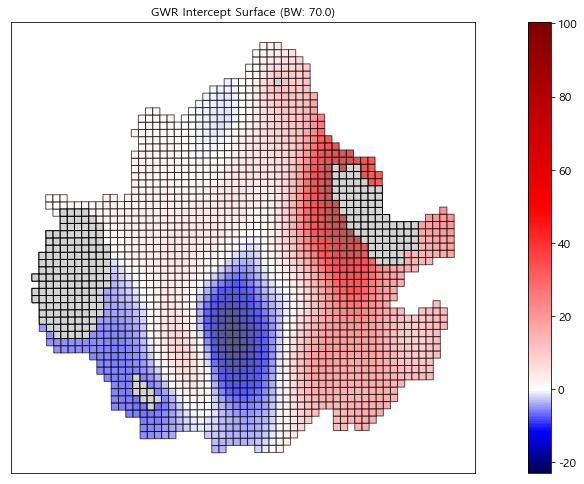

In [63]:
# cctv
GWR_coef_plot('gwr_x12')

In [64]:
gwr_coef_df = gpd.read_file("교통_250격자_GWR계수.geojson",driver="GeoJSON")
gwr_coef_df.head(2)

,상업시설_격자별개수,차로수,상업지역면적,횡단보도_격자별개수,주거지역면적,신호등_격자별개수,업무시설_격자별개수,오거리_격자별개수,주거용건축물면적,교육환경보호구역_Buffer면적,공동주거건축물,지하철_격자별개수,const,gid,geometry
0,0.330568,90.065049,43.338938,28.991012,0.534185,2.773694,-8.143514,182.895130,70.229485,-8.666634,5.534012,18.335831,-6.393555,다사49aa19ab,"MULTIPOLYGON (((126.92477 37.27077, 126.92475 ..."
1,0.343127,88.775159,43.408644,30.345524,0.234270,2.385330,-7.729992,178.474073,71.451242,-8.387210,6.183346,18.266486,-6.213230,다사49aa19ba,"MULTIPOLYGON (((126.92475 37.27302, 126.92473 ..."


## 회귀계수 클러스터링

In [65]:
from sklearn.cluster import KMeans 
# 스케일링 놉.
# from sklearn.preprocessing import MinMaxScaler
# scaler=MinMaxScaler()

df=gwr_coef_df.drop(['gid', 'geometry'], axis=1)
# df_copy_scale=scaler.fit_transform(df)
# df_copy_scale=pd.DataFrame(df_copy_scale, columns=df.columns)
# df_copy_scale

In [66]:
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

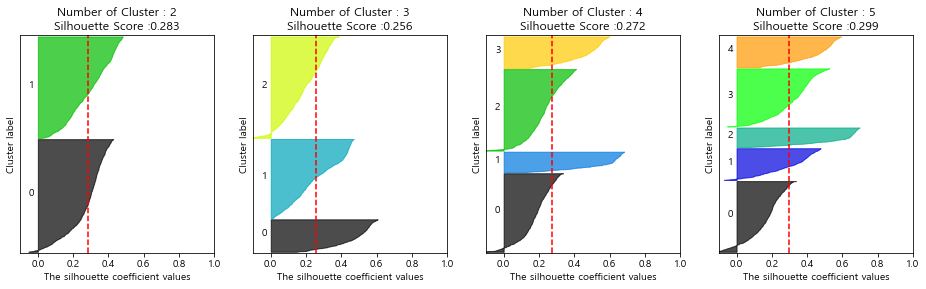

In [67]:
visualize_silhouette([ 2, 3, 4, 5], df)

In [68]:
# k-means clustering 실행(여기 숫자 바꾸면 됨)
kmeans = KMeans(n_clusters=4)
kmeans.fit(df)  

# 결과 확인
result_by_sklearn = df.copy()
result_by_sklearn["cluster"] = kmeans.labels_
#result_by_sklearn['관할경찰서']=df['관할경찰서']
result_by_sklearn

,상업시설_격자별개수,차로수,상업지역면적,횡단보도_격자별개수,주거지역면적,신호등_격자별개수,업무시설_격자별개수,오거리_격자별개수,주거용건축물면적,교육환경보호구역_Buffer면적,공동주거건축물,지하철_격자별개수,const,cluster
0,0.330568,90.065049,43.338938,28.991012,0.534185,2.773694,-8.143514,182.895130,70.229485,-8.666634,5.534012,18.335831,-6.393555,2
1,0.343127,88.775159,43.408644,30.345524,0.234270,2.385330,-7.729992,178.474073,71.451242,-8.387210,6.183346,18.266486,-6.213230,2
2,0.371107,86.933669,43.614742,32.985428,-0.300139,1.585922,-7.088387,166.685240,73.969378,-7.736670,7.408569,17.953687,-5.657383,2
3,0.269996,97.043876,43.687467,23.444737,2.104684,4.331341,-11.126748,189.695446,66.811921,-9.285503,2.726249,18.288509,-6.940278,2
4,0.291814,94.283904,43.565453,24.733674,1.597249,4.064543,-10.233125,192.797257,66.914816,-9.394138,3.458705,18.331147,-6.818568,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2085,-1.463703,102.769984,21.363224,7.936513,41.016921,14.568861,-8.288100,-0.323143,12.861008,12.698843,-13.370798,1.282397,26.754280,3
2086,-1.516059,103.845486,21.085363,9.147856,43.531196,14.524468,-10.906545,0.902956,13.694853,13.473933,-13.171114,3.790181,28.396483,3
2087,-1.488241,102.969863,20.500005,9.424592,45.267857,14.217991,-11.817020,0.725651,13.811107,13.695944,-12.945472,4.870218,29.104478,3
2088,-1.529788,104.636085,20.465594,10.721332,47.227169,14.115730,-14.105585,1.903591,14.670657,14.394609,-12.750797,7.115265,30.361350,3


### GMM


from sklearn.mixture import GaussianMixture
import pandas as pd

gaussian = GaussianMixture(n_components=3,random_state=0)
# 회귀 계수 시각화 그림 보면 3개도 해보기

gaussian_label = gaussian.fit_predict(df.values)
print("cluster labels 유형 :",np.unique(gaussian_label))

gwr_coef_df_cluster = gwr_coef_df
gwr_coef_df_cluster["cluster"] = gaussian_label

gwr_coef_df_cluster.to_file("교통_250격자_GWR계수_3개군집.geojson",driver="GeoJSON")

In [95]:
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
import pandas as pd

gaussian = BayesianGaussianMixture(n_components=4,random_state=0)
# 회귀 계수 시각화 그림 보면 4개 정도가 적당

gaussian_label = gaussian.fit_predict(df.values)
print("cluster labels 유형 :",np.unique(gaussian_label))

cluster labels 유형 : [0 1 2 3]


In [99]:
gwr_coef_df_cluster = gwr_coef_df
gwr_coef_df_cluster["cluster"] = gaussian_label

gwr_coef_df_cluster.to_file("교통_250격자_GWR계수_4개군집.geojson",driver="GeoJSON")

In [24]:
gwr_coef_df_cluster = gpd.read_file("교통_250격자_GWR계수_4개군집.geojson",driver="GeoJSON")
gwr_coef_df_cluster.head(2)

gwr_coef_df = gwr_coef_df_cluster

## 클러스터 시각화

In [73]:
gwr_coef_df_cluster

,상업시설_격자별개수,차로수,상업지역면적,횡단보도_격자별개수,주거지역면적,신호등_격자별개수,업무시설_격자별개수,오거리_격자별개수,주거용건축물면적,교육환경보호구역_Buffer면적,공동주거건축물,지하철_격자별개수,const,gid,geometry,cluster
0,0.330568,90.065049,43.338938,28.991012,0.534185,2.773694,-8.143514,182.895130,70.229485,-8.666634,5.534012,18.335831,-6.393555,다사49aa19ab,"MULTIPOLYGON (((126.92477 37.27077, 126.92475 ...",1
1,0.343127,88.775159,43.408644,30.345524,0.234270,2.385330,-7.729992,178.474073,71.451242,-8.387210,6.183346,18.266486,-6.213230,다사49aa19ba,"MULTIPOLYGON (((126.92475 37.27302, 126.92473 ...",1
2,0.371107,86.933669,43.614742,32.985428,-0.300139,1.585922,-7.088387,166.685240,73.969378,-7.736670,7.408569,17.953687,-5.657383,다사49aa20aa,"MULTIPOLYGON (((126.92472 37.27753, 126.92470 ...",1
3,0.269996,97.043876,43.687467,23.444737,2.104684,4.331341,-11.126748,189.695446,66.811921,-9.285503,2.726249,18.288509,-6.940278,다사49ab18ab,"MULTIPOLYGON (((126.92766 37.26177, 126.92764 ...",1
4,0.291814,94.283904,43.565453,24.733674,1.597249,4.064543,-10.233125,192.797257,66.914816,-9.394138,3.458705,18.331147,-6.818568,다사49ab18ba,"MULTIPOLYGON (((126.92764 37.26402, 126.92762 ...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2085,-1.463703,102.769984,21.363224,7.936513,41.016921,14.568861,-8.288100,-0.323143,12.861008,12.698843,-13.370798,1.282397,26.754280,다사63ba21aa,"MULTIPOLYGON (((127.08822 37.28722, 127.08821 ...",0
2086,-1.516059,103.845486,21.085363,9.147856,43.531196,14.524468,-10.906545,0.902956,13.694853,13.473933,-13.171114,3.790181,28.396483,다사63ba21ab,"MULTIPOLYGON (((127.08821 37.28947, 127.08820 ...",0
2087,-1.488241,102.969863,20.500005,9.424592,45.267857,14.217991,-11.817020,0.725651,13.811107,13.695944,-12.945472,4.870218,29.104478,다사63ba21ba,"MULTIPOLYGON (((127.08820 37.29173, 127.08819 ...",0
2088,-1.529788,104.636085,20.465594,10.721332,47.227169,14.115730,-14.105585,1.903591,14.670657,14.394609,-12.750797,7.115265,30.361350,다사63ba21bb,"MULTIPOLYGON (((127.08819 37.29398, 127.08818 ...",0


In [97]:
#gwr_coef_df['cluster']=result_by_sklearn['cluster']
gwr_coef_df['cluster'] = gaussian_label

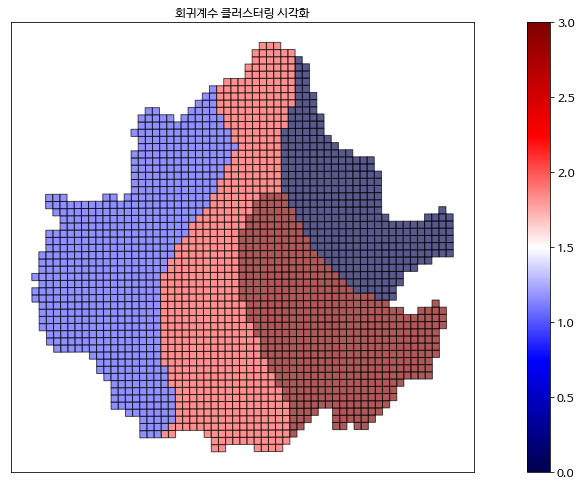

In [25]:
#Prep plot and add axis
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
ax.set_title('회귀계수 클러스터링 시각화', fontsize=12)

#Set color map
cmap = plt.cm.seismic

#Find min and max values of the combined dataset
gwr_min = gwr_coef_df['cluster'].min()
gwr_max = gwr_coef_df['cluster'].max()
vmin = np.min([gwr_min])
vmax = np.max([gwr_max])

#Create scalar mappable for colorbar and stretch colormap across range of data values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

#Plot GWR parameters
gwr_coef_df.plot('cluster', cmap=sm.cmap, ax=ax, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})

#Set figure options and plot 
fig.tight_layout()    
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=12) 
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

In [76]:
coef_cluster_mean_df=result_by_sklearn.groupby(['cluster']).median().transpose()
coef_cluster_mean_df.to_csv('coef_cluster_mean.csv', index=False)
coef_cluster_mean_df

cluster,0,1,2,3
상업시설_격자별개수,-2.481776,0.078092,0.343431,-1.096134
차로수,130.939596,125.718120,83.730912,75.259603
상업지역면적,50.155318,36.795979,44.005442,18.711462
횡단보도_격자별개수,27.113484,19.717007,32.117429,2.277062
주거지역면적,29.805385,14.697078,2.135793,51.022807
신호등_격자별개수,18.725524,1.112720,4.056322,11.179572
업무시설_격자별개수,-27.831240,-8.724137,-10.621695,-17.301090
오거리_격자별개수,25.578443,81.799381,167.073026,-3.287692
주거용건축물면적,11.441135,25.270006,70.653388,9.390975
교육환경보호구역_Buffer면적,15.401626,-1.824599,-7.245549,12.328119


In [77]:
np.save("coef_cluster_mean_교통.npy",kmeans.cluster_centers_)